Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original image shape: (5792, 4344, 3)


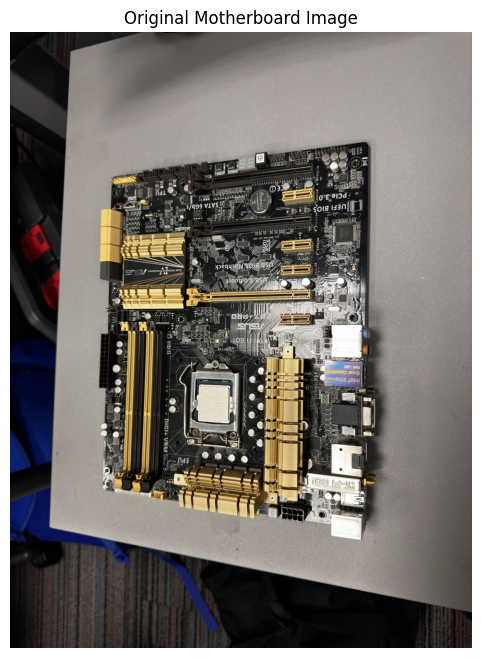

In [1]:
# STEP 1.1: Imports, Drive mount, and image load
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

# Path to image folder on Drive
DATA_ROOT = "/content/drive/MyDrive/Project 3 Data"
IMG_PATH  = os.path.join(DATA_ROOT, "motherboard_image.JPEG")

# Read original image in BGR format
original_image = cv2.imread(IMG_PATH)

# Simple check the image loaded correctly
if original_image is None:
    raise FileNotFoundError(f"Could not load image at: {IMG_PATH}")

print("Original image shape:", original_image.shape)

# Convert BGR to RGB for plotting
original_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 8))
plt.title("Original Motherboard Image")
plt.imshow(original_rgb)
plt.axis("off")
plt.show()


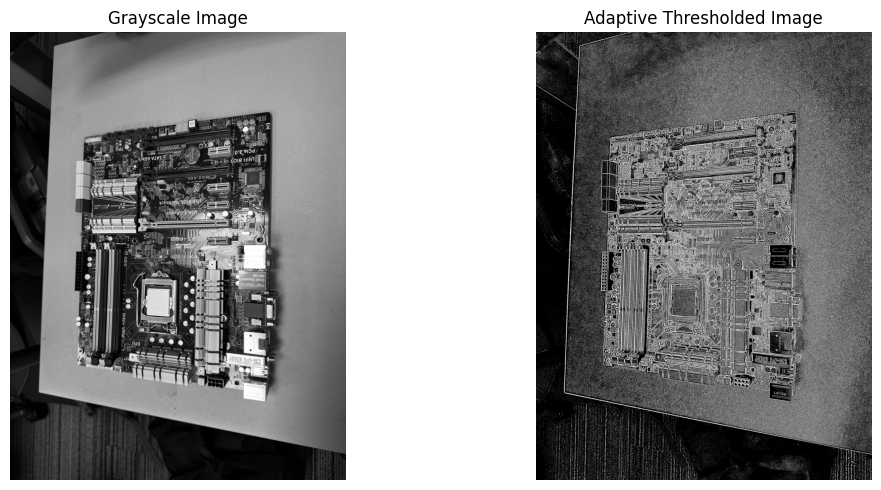

In [2]:
# STEP 1.2: Grayscale conversion and adaptive thresholding

# Convert to grayscale
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Adaptive threshold (local) with inversion so board/table appear white
adaptive_thresh = cv2.adaptiveThreshold(
    gray_image,
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=15,
    C=2,
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Grayscale Image")
plt.imshow(gray_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Adaptive Thresholded Image")
plt.imshow(adaptive_thresh, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


Total contours found: 228115
Contours after area filtering: 38
Largest contour area: 6462381.0


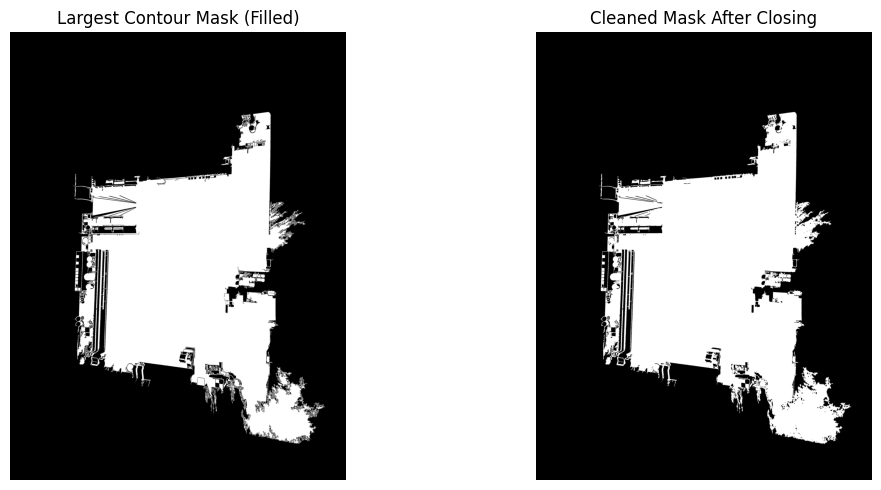

In [3]:
# STEP 1.3: Contour detection and largest-object mask

# Find external contours on the binary image
contours, _ = cv2.findContours(
    adaptive_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

print("Total contours found:", len(contours))

# Filter out tiny contours by area
area_threshold = 5000
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > area_threshold]
print("Contours after area filtering:", len(filtered_contours))

# Select the largest remaining contour (assumed to be the PCB/table region)
largest_contour = max(filtered_contours, key=cv2.contourArea)
print("Largest contour area:", cv2.contourArea(largest_contour))

# Create an empty mask and fill the largest contour
mask = np.zeros_like(gray_image, dtype=np.uint8)
cv2.drawContours(mask, [largest_contour], contourIdx=-1, color=255, thickness=cv2.FILLED)

# Morphological closing to fill small gaps and smooth boundary
kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
cleaned_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_close)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Largest Contour Mask (Filled)")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Cleaned Mask After Closing")
plt.imshow(cleaned_mask, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


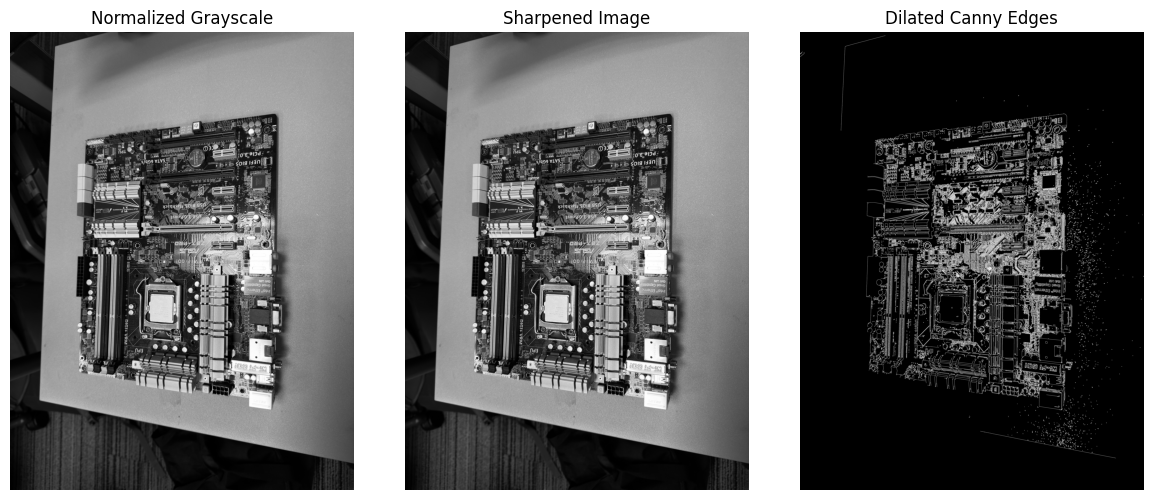

In [4]:
# STEP 1.4: Edge enhancement and Canny edges

# Normalize grayscale for better contrast
norm_image = cv2.normalize(gray_image, None, 0, 255, cv2.NORM_MINMAX)

# Simple sharpening filter
sharpen_kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]], dtype=np.float32)
sharpened_image = cv2.filter2D(norm_image, -1, sharpen_kernel)

# Gaussian blur to suppress high-frequency noise
smoothed_image = cv2.GaussianBlur(sharpened_image, (7, 7), 0)

# Canny edge detection
low_threshold  = 80
high_threshold = 180
edges = cv2.Canny(smoothed_image, low_threshold, high_threshold)

# Dilate edges to make them more visible
kernel_edge = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
dilated_edges = cv2.dilate(edges, kernel_edge, iterations=1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.title("Normalized Grayscale")
plt.imshow(norm_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Sharpened Image")
plt.imshow(sharpened_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Dilated Canny Edges")
plt.imshow(dilated_edges, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


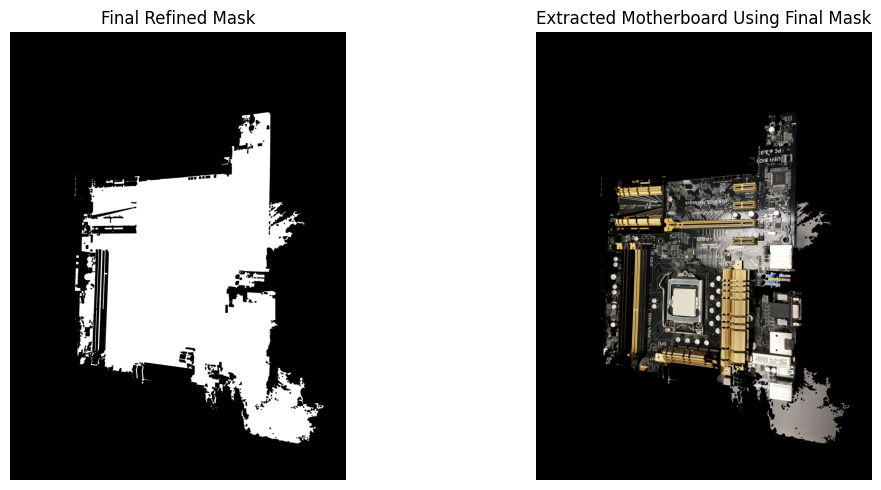

In [5]:
# STEP 1.5: Refine mask and extract PCB using bitwise_and

# Use a larger kernel for more aggressive smoothing
kernel_refine = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))

# Another closing to seal any remaining gaps
closed_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel_refine)

# Erode slightly to shrink mask and remove thin border artifacts
eroded_mask = cv2.erode(closed_mask, kernel_refine, iterations=1)

# Apply final mask to original image
refined_masked_image = cv2.bitwise_and(original_image, original_image, mask=eroded_mask)
refined_rgb = cv2.cvtColor(refined_masked_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Final Refined Mask")
plt.imshow(eroded_mask, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Extracted Motherboard Using Final Mask")
plt.imshow(refined_rgb)
plt.axis("off")

plt.tight_layout()
plt.show()


In [6]:
# STEP 2.0: Locate data.yaml automaticall

import os

DATA_ROOT = "/content/drive/MyDrive/Project 3 Data"

DATA_YAML = None

for root, dirs, files in os.walk(DATA_ROOT):
    if "data.yaml" in files:
        DATA_YAML = os.path.join(root, "data.yaml")
        break

print("FOUND YAML:", DATA_YAML)


FOUND YAML: /content/drive/MyDrive/Project 3 Data/data/data.yaml


In [7]:
# STEP 2.1 – Install Ultralytics and import package
!pip install -q ultralytics

import os
import torch
from ultralytics import YOLO

# Check that we have a GPU
print("PyTorch device:", "cuda" if torch.cuda.is_available() else "cpu")

# DATA_YAML was found in Step 2.0 – just print to double-check
print("Using dataset yaml:", DATA_YAML)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PyTorch device: cuda
Using dataset yaml: /content/drive/MyDrive/Project 3 Data/data/data.yaml


In [8]:
# STEP 2.2 – Create YOLOv11 model and set training config

# Use YOLOv11 nano as the pretrained backbone
model = YOLO("yolo11n.pt")   # downloads automatically the first time

# Lighter config to avoid OOM on Colab
EPOCHS     = 30      # enough to learn, not too long
IMG_SIZE   = 640     # smaller than 960, much less memory
BATCH_SIZE = 8       # if this still OOMs, drop to 4
MODEL_NAME = "pcb_yolo11n_base"

print(f"Model ready. Will train for {EPOCHS} epochs at img size {IMG_SIZE}.")

base_results = model.train(
    data=DATA_YAML,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    name=MODEL_NAME,
    project=os.path.join(DATA_ROOT, "runs")
)


Model ready. Will train for 30 epochs at img size 640.
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Project 3 Data/data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pcb_yolo11n_base, nbs=64, nms=False, opset=None, optimize=Fa

In [9]:
# Create a fresh YOLOv11 model for a higher-epoch training run
high_model = YOLO("yolo11n.pt")

HIGH_EPOCHS   = 60     # higher than 30 but still reasonable
HIGH_IMGSZ    = 900    # higher size to capture more detail
HIGH_BATCH    = 4      # smaller batch to reduce load
HIGH_RUN_NAME = "pcb_yolo11n_high"

high_epoch_results = high_model.train(
    data=DATA_YAML,
    epochs=HIGH_EPOCHS,     # higher epoch count (still < 200)
    imgsz=HIGH_IMGSZ,
    batch=HIGH_BATCH,       # smaller batch = less VRAM
    name=HIGH_RUN_NAME,
    project=os.path.join(DATA_ROOT, "runs")
)


Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Project 3 Data/data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=900, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pcb_yolo11n_high3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, 

In [12]:
# STEP 2.3 – Train YOLO model on PCB dataset

from ultralytics import YOLO

model = YOLO("yolo11n.pt")

results = model.train(
    data=DATA_YAML,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    name=MODEL_NAME,
    project=os.path.join(DATA_ROOT, "runs")
)

best_weights_path = os.path.join(DATA_ROOT, "runs", "detect", MODEL_NAME, "weights", "best.pt")
print("Best weights saved at:", best_weights_path)


Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Project 3 Data/data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pcb_yolo11n_base2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, 

In [13]:
# STEP 2.4 – Validate trained model on validation split

val_metrics = model.val(data=DATA_YAML)
print("Validation metrics:", val_metrics)


Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,584,687 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.7±0.7 ms, read: 100.2±59.8 MB/s, size: 285.2 KB)
val: Scanning /content/drive/MyDrive/Project 3 Data/data/valid/labels.cache... 105 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 105/105 169.3Kit/s 0.0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 26, len(boxes) = 19108. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 2.7s/it 19.1s
                   all        105      19108      0.691      0.271      0.322      0.215
                Button         14         45      0.655      0.444      0.508       0.41
             Ca

In [16]:
# STEP 2.5 – Print exact YOLO save directories

print("BASE save dir:", base_results.save_dir)
print("HIGH save dir:", high_epoch_results.save_dir)


BASE save dir: /content/drive/MyDrive/Project 3 Data/runs/pcb_yolo11n_base
HIGH save dir: /content/drive/MyDrive/Project 3 Data/runs/pcb_yolo11n_high3


In [14]:
# STEP 3.0 – Paths and setup for evaluation
import os
import yaml
from ultralytics import YOLO

DATA_ROOT = "/content/drive/MyDrive/Project 3 Data"
DATA_YAML = None
for root, dirs, files in os.walk(DATA_ROOT):
    if "data.yaml" in files:
        DATA_YAML = os.path.join(root, "data.yaml")
        break

print("Using DATA_YAML:", DATA_YAML)

# Names used in Step 2 training
BASE_NAME = "pcb_yolo11n_base"
HIGH_NAME = "pcb_yolo11n_high"

RUNS_DIR = os.path.join(DATA_ROOT, "runs", "detect")

base_weights = os.path.join(RUNS_DIR, BASE_NAME, "weights", "best.pt")
high_weights = os.path.join(RUNS_DIR, HIGH_NAME, "weights", "best.pt")

print("Base weights:", base_weights)
print("High weights:", high_weights, "(may not exist if you skipped Run 2)")


Using DATA_YAML: /content/drive/MyDrive/Project 3 Data/data/data.yaml
Base weights: /content/drive/MyDrive/Project 3 Data/runs/detect/pcb_yolo11n_base/weights/best.pt
High weights: /content/drive/MyDrive/Project 3 Data/runs/detect/pcb_yolo11n_high/weights/best.pt (may not exist if you skipped Run 2)


In [17]:
# STEP 3.1 – Quantitative Evaluation on Test Set

from ultralytics import YOLO
import os

# Paths from Step 2.5
base_run_dir = "/content/drive/MyDrive/Project 3 Data/runs/pcb_yolo11n_base"
high_run_dir = "/content/drive/MyDrive/Project 3 Data/runs/pcb_yolo11n_high3"

base_weights = os.path.join(base_run_dir, "weights", "best.pt")
high_weights = os.path.join(high_run_dir, "weights", "best.pt")

# Load models
base_model = YOLO(base_weights)
high_model = YOLO(high_weights)

print("Running evaluation on TEST split...")

# Evaluate both models on the test set
base_metrics = base_model.val(data=DATA_YAML, split="test")
high_metrics = high_model.val(data=DATA_YAML, split="test")

print("\n==== Base Model Metrics (Low Epoch) ====")
print(base_metrics)

print("\n==== High-Epoch Model Metrics ====")
print(high_metrics)


Running evaluation on TEST split...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,584,687 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 0.7±0.5 MB/s, size: 655.5 KB)
val: Scanning /content/drive/MyDrive/Project 3 Data/data/test/labels... 22 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 22/22 1.8s/it 39.3s
val: New cache created: /content/drive/MyDrive/Project 3 Data/data/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 3.3s/it 6.6s
                   all         22       3143      0.617      0.223      0.229      0.143
                Button          6         17      0.287      0.118     0.0457     0.0228
             Capacitor         20       1162      0.704      0.209      0.338      0.181
             Connector         20        303      0.622      0.594      0.652      0.434
     

In [21]:
# STEP 3.2 – Qualitative Evaluation on 3 PCB Images (auto-detect)
import os

# Look for eval images under DATA_ROOT whose name contains "pcb_eval"
EVAL_ROOT = DATA_ROOT
candidate_images = []

for root, dirs, files in os.walk(EVAL_ROOT):
    for f in files:
        fname_lower = f.lower()
        if fname_lower.endswith((".jpg", ".jpeg", ".png")) and "pcb_eval" in fname_lower:
            candidate_images.append(os.path.join(root, f))

print("Found candidate eval images:")
for p in candidate_images:
    print("  ", p)

# If fewer than 3 found, fall back to the first 3 jpg/png in DATA_ROOT
if len(candidate_images) < 3:
    print("\nFewer than 3 'pcb_eval' images found; falling back to generic images.")
    candidate_images = []
    for root, dirs, files in os.walk(EVAL_ROOT):
        for f in files:
            if f.lower().endswith((".jpg", ".jpeg", ".png")):
                candidate_images.append(os.path.join(root, f))
    # just keep first 3
    candidate_images = sorted(candidate_images)[:3]

# Tag them as "1", "2", "3" for naming the results
eval_images = []
for i, path in enumerate(candidate_images[:3], start=1):
    eval_images.append((str(i), path))

print("\nUsing these 3 images for qualitative eval:")
for tag, path in eval_images:
    print(f"  Image {tag}: {path}")

# Root folder where YOLO will save eval outputs
EVAL_PROJECT = os.path.join(DATA_ROOT, "runs", "eval")
os.makedirs(EVAL_PROJECT, exist_ok=True)

for tag, img_path in eval_images:
    print(f"\n=== Evaluating image {tag}: {img_path} ===")

    # Low-epoch (base) model prediction
    base_model.predict(
        source=img_path,
        save=True,
        project=EVAL_PROJECT,
        name=f"results{tag}_low_epoch",
        exist_ok=True
    )

    # High-epoch model prediction
    high_model.predict(
        source=img_path,
        save=True,
        project=EVAL_PROJECT,
        name=f"results{tag}_high_epoch",
        exist_ok=True
    )

print("\nQualitative results saved under:", EVAL_PROJECT)
print("Check folders like results1_low_epoch, results1_high_epoch, etc.")


Found candidate eval images:

Fewer than 3 'pcb_eval' images found; falling back to generic images.

Using these 3 images for qualitative eval:
  Image 1: /content/drive/MyDrive/Project 3 Data/data/evaluation/ardmega.jpg
  Image 2: /content/drive/MyDrive/Project 3 Data/data/evaluation/arduno.jpg
  Image 3: /content/drive/MyDrive/Project 3 Data/data/evaluation/rasppi.jpg

=== Evaluating image 1: /content/drive/MyDrive/Project 3 Data/data/evaluation/ardmega.jpg ===

image 1/1 /content/drive/MyDrive/Project 3 Data/data/evaluation/ardmega.jpg: 576x640 3 Capacitors, 5 Connectors, 10 ICs, 27 Resistors, 49.4ms
Speed: 4.5ms preprocess, 49.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)
Results saved to /content/drive/MyDrive/Project 3 Data/runs/eval/results1_low_epoch

image 1/1 /content/drive/MyDrive/Project 3 Data/data/evaluation/ardmega.jpg: 832x928 1 Button, 13 Capacitors, 10 Connectors, 7 ICs, 21 Resistors, 51.6ms
Speed: 6.9ms preprocess, 51.6ms inference, 1.4ms postp

In [22]:
# STEP 3.3 – Numerical Comparison Summary

# base_metrics and high_metrics come from Step 3.1 (base_model.val / high_model.val)

def print_metrics(label, metrics):
    # Simple helper to print key YOLO metrics
    print(f"\n=== {label} ===")
    try:
        print(f"mAP@0.5      : {metrics.box.map50:.4f}")
        print(f"mAP@0.5:0.95 : {metrics.box.map:.4f}")
        print(f"Precision    : {metrics.box.mp:.4f}")
        print(f"Recall       : {metrics.box.mr:.4f}")
    except Exception as e:
        print("Could not read metric fields cleanly:", e)
        print("Raw metrics object:", metrics)

print_metrics("Base Model (low epoch)", base_metrics)
print_metrics("High-Epoch Model", high_metrics)


=== Base Model (low epoch) ===
mAP@0.5      : 0.2286
mAP@0.5:0.95 : 0.1432
Precision    : 0.6166
Recall       : 0.2227

=== High-Epoch Model ===
mAP@0.5      : 0.5381
mAP@0.5:0.95 : 0.3703
Precision    : 0.5953
Recall       : 0.5230

Use these values later in the Step 3 discussion section of your report.
